In [41]:
## Training the optimized wavpool via the param, with a different split of the dataset, and run that sucker. 

from wavNN.training.train_model import TrainingLoop
from wavNN.models.wavpool import WavPool
from sklearn.metrics import confusion_matrix as confusion 

from wavNN.data_generators.cifar_generator import CIFARGenerator
from wavNN.data_generators.mnist_generator import MNISTGenerator
from wavNN.data_generators.fashion_mnist_generator import FashionMNISTGenerator

import json 
import os 
import matplotlib.pyplot as plt 

import pandas as pd
import torch 



In [5]:
def get_params(dataset_name): 
    optimize_path = f"../results/optimize_params"
    dir_name = [directory for directory in os.listdir(optimize_path) if ("WavPool" in directory) and (dataset_name in directory)][0]
    file_name = f"{optimize_path}/{dir_name.rstrip('/')}/experiment_config.json"
    with open(file_name, 'r') as f: 
        exp_params = json.load(f)
    return exp_params

In [13]:
def train_model(dataset_name, dataset): 
    exp_params = get_params(dataset_name)

    loop = TrainingLoop(
        model_class=WavPool, 
        model_params=exp_params['model_kwargs'], 
        data_class=dataset, 
        data_params=exp_params['data_kwargs'], 
        optimizer_class=torch.optim.SGD, 
        optimizer_config=exp_params['optimizer_kwargs'], 
        loss=torch.nn.CrossEntropyLoss, epochs=120)
    loop()

    save_path = f"../results/wavpool_inference_{dataset_name}/"
    loop.save(save_path=save_path)
    test_data = loop.data_loader['test']
    
    return loop.model, test_data


In [18]:
def predict(model, data_loader): 
    predictions = torch.tensor([])
    labels = torch.tensor([])
    for i, batch in enumerate(data_loader):
        data_input, label = batch
        model_prediction = model(data_input)

        labels = torch.concat([labels, label])
        predictions = torch.concat([predictions, model_prediction])
    return predictions, labels

In [49]:
def confusion_matrix(predictions, labels):   
    num_classes = [i for i in range(predictions.shape[1])]
    _, predicted_class = torch.max(predictions, 1)
    c = confusion(
        labels.ravel(), predicted_class.ravel(), labels=num_classes
        )
    return c


In [26]:
mnist_model, test_data = train_model("_MNIST", MNISTGenerator)
mnist_pred, mnist_label = predict(mnist_model, test_data)

Training....: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 22.67it/s]


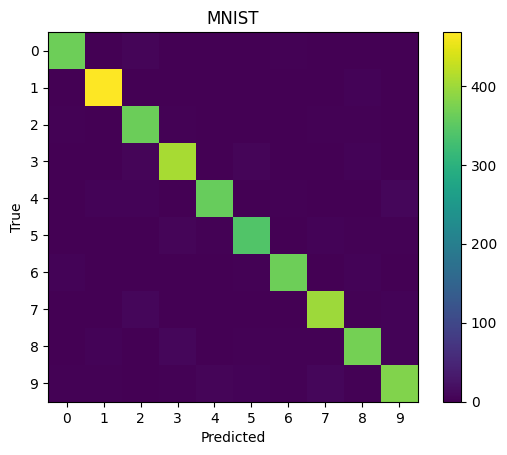

In [45]:
confusion_matrix(mnist_pred, mnist_label)
plt.colorbar()
plt.title("MNIST")
plt.yticks(ticks=[i for i in range(10)], labels=[i for i in range(10)])
plt.xticks(ticks=[i for i in range(10)], labels=[i for i in range(10)])

plt.show()

In [32]:
fmnist_model, test_data = train_model("FashionMNIST", FashionMNISTGenerator)
fmnist_pred, fmnist_label = predict(fmnist_model, test_data)

Training....: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 24.08it/s]


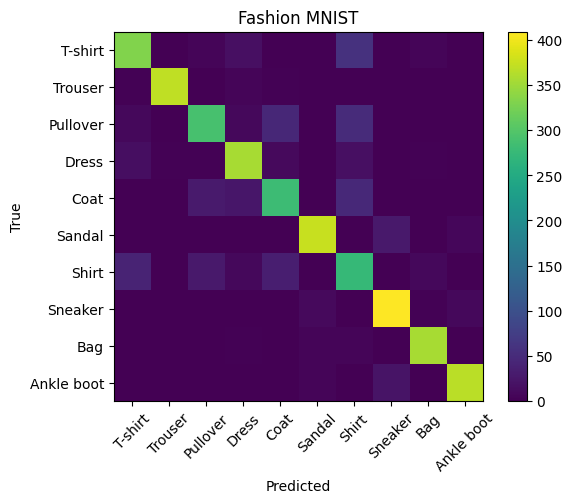

In [46]:
confusion_matrix(fmnist_pred, fmnist_label)
plt.colorbar()
plt.title("Fashion MNIST")
labels =['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
plt.yticks(ticks=[i for i in range(10)], labels=labels)
plt.xticks(ticks=[i for i in range(10)], labels=labels, rotation=45)

plt.show()

In [37]:
cifarmodel, test_data = train_model("CIFAR", CIFARGenerator)
cifar_pred, cifar_label = predict(cifarmodel, test_data)

Files already downloaded and verified


Training....: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16.65it/s]


In [40]:
cifar_label.unique()

tensor([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

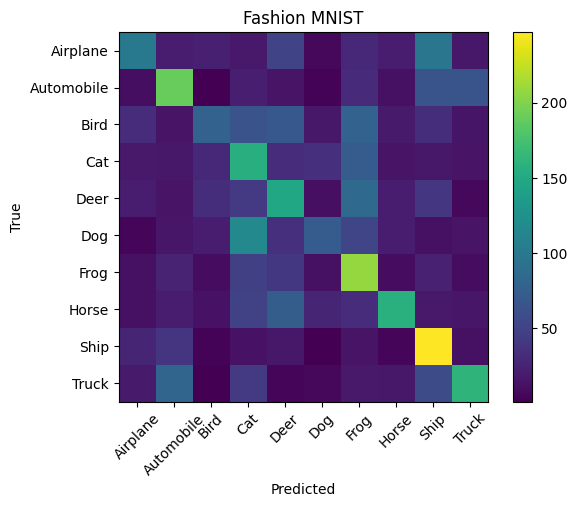

In [47]:
confusion_matrix(cifar_pred, cifar_label)
plt.colorbar()
plt.title("CIFAR-10")

labels =['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
plt.yticks(ticks=[i for i in range(10)], labels=labels)
plt.xticks(ticks=[i for i in range(10)], labels=labels, rotation=45)

plt.show()

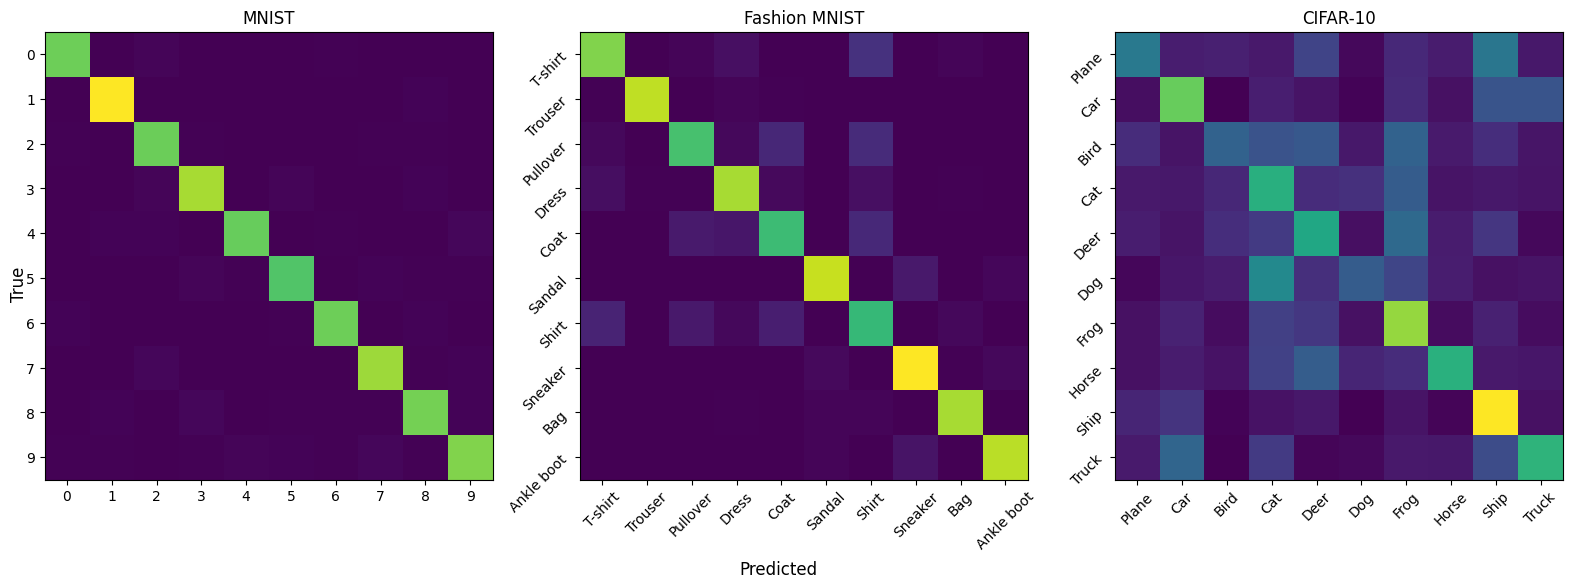

In [66]:
c_mnist = confusion_matrix(mnist_pred, mnist_label)
c_fmnist = confusion_matrix(fmnist_pred, fmnist_label)
c_cifar = confusion_matrix(cifar_pred, cifar_label)

fig, subplots = plt.subplots(1, 3, figsize=(16, 6))

subplots[0].imshow(c_mnist)
subplots[0].set_yticks(ticks=[i for i in range(10)], labels=[i for i in range(10)])
subplots[0].set_xticks(ticks=[i for i in range(10)], labels=[i for i in range(10)])
subplots[0].set_title("MNIST")


subplots[1].imshow(c_fmnist)
labels =['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

subplots[1].set_yticks(ticks=[i for i in range(10)], labels=labels, rotation=45)
subplots[1].set_xticks(ticks=[i for i in range(10)], labels=labels, rotation=45)
subplots[1].set_title("Fashion MNIST")

subplots[2].imshow(c_cifar)
labels =['Plane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

subplots[2].set_yticks(ticks=[i for i in range(10)], labels=labels, rotation=45)
subplots[2].set_xticks(ticks=[i for i in range(10)], labels=labels, rotation=45)
subplots[2].set_title("CIFAR-10")


fig.supxlabel('Predicted')
fig.supylabel('True')
plt.tight_layout()

plt.show()